In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import  matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 15)

import sys
import os

sys.path.append(os.path.join(os.path.abspath('.'),'../../plankton'))

In [2]:
import plankton as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [12]:
data_folder='data/leftCA1/'

xiaoyan_et_al = pd.read_csv(os.path.join(data_folder,'spots_w_segmentation_leftCA1_4-3.csv'))
signatures = pd.read_csv(os.path.join(data_folder,'../signatures_proteinaltlas_xiaoyan.csv'),index_col=0)

dapi_segments = plt.imread(os.path.join(data_folder,'./CA1DapiBoundaries_4-3_left.tif'))
dapi_segments = 1-(dapi_segments/dapi_segments.max())



bg_cells= np.load('./data/leftCA1/label_image.coo.npz')
cell_mask = np.zeros(bg_cells['shape'])
cell_mask[bg_cells['row'],bg_cells['col']]=bg_cells['data']

In [13]:
sdata = pl.SpatialData(genes=xiaoyan_et_al.gene,
                       x_coordinates=xiaoyan_et_al.spotX,
                       y_coordinates=xiaoyan_et_al.spotY,
                      pixel_maps=[pl.PixelMap(dapi_segments),pl.PixelMask(cell_mask)])

(<matplotlib.collections.PathCollection at 0x7f408cdca2e0>, None, None)

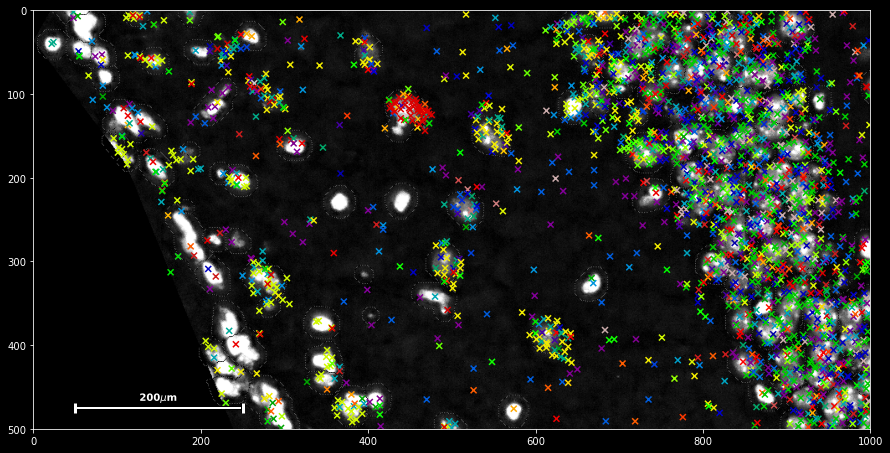

In [22]:
sdata.spatial[0:1000,500:1000,].scatter(marker='x',alpha=1)

In [48]:
((sdata.pixel_maps[0]).get_value(sdata.y,sdata.x)).mean()

[   3    3    3 ... 2433 2360 2257]


0.023602630342883985

In [5]:
knn_neighbors=200
bandwidth=60
n_neighbors=30
metric='euclidean'
min_dist=0.03
random_state=42
zero_weight=1

_=sdata.graph.update_knn(n_neighbors=knn_neighbors)

sdata.graph.run_umap(bandwidth=bandwidth,n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state,zero_weight=zero_weight)



In [5]:
signatures=np.random.random(size=(96,29))

In [15]:
signatures-=signatures.mean(0)
# signatures/=signatures.std(0)

In [6]:
import utils
import time

t0=time.perf_counter()
ct_map = utils.ssam(sdata,signatures,patch_length=500)
print(time.perf_counter()-t0)

86.65996215999621


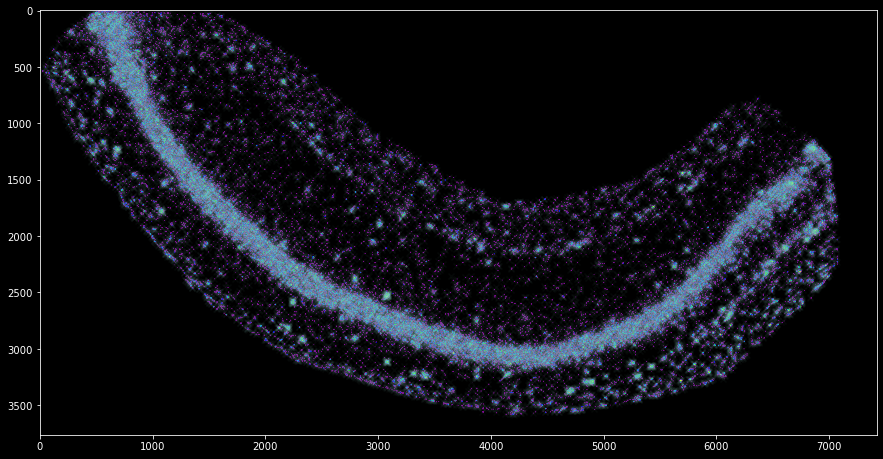

In [10]:
plt.imshow(ct_map,cmap='nipy_spectral')

plt.scatter(*sdata.coordinates.T,marker='x',alpha=0.04)

In [71]:
mask = norm>0.02

exps=hists[:,mask]
exps=exps-exps.mean(0)

In [82]:
signatures -= signatures.mean(0)
signatures /= signatures.std(0)

exps-=exps.mean(0)
exps-=exps.std(0)
# .shape,exps.shape

In [113]:
sdata.stats.loc[sdata.spatial[:500,:500].genes].gene_ids.values

array([ 0,  1,  3,  4,  5,  7, 10, 11, 12, 15, 16, 18, 19, 22, 23, 25, 26,
       27, 28, 32, 33, 34, 36, 38, 40, 41, 42, 44, 45, 46, 48, 49, 51, 52,
       55, 56, 58, 59, 61, 63, 67, 72, 73, 75, 76, 77, 80, 81, 82, 84, 90,
       91, 92, 93])

In [84]:
out=np.inner(exps.T,signatures.T)


-0.1493319215999319

In [87]:
ctmap=mask.copy().astype(int)
ctmap[mask]=out.argmax(1)


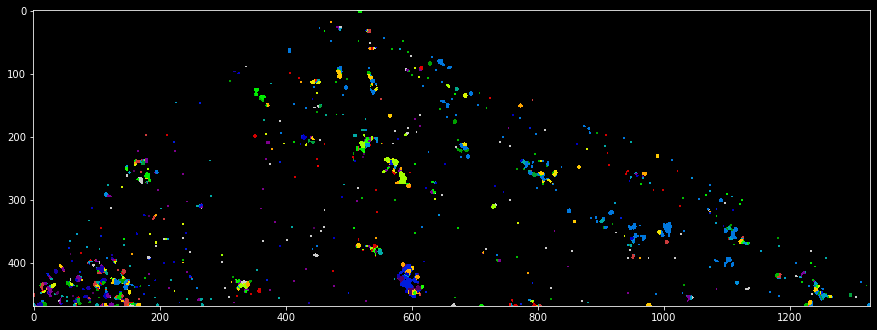

In [88]:
# plt.plot(sorted(ctmap.flatten()))
plt.imshow(ctmap,cmap='nipy_spectral',interpolation='none')


In [ ]:
plt.figure(figsize=(25,5))
plt.imshow(localmaxs,aspect='auto')

In [ ]:
# knn_neighbors=100
# bandwidth=4
# n_neighbors=30
# metric='euclidean'
# min_dist=0.0
# random_state=42
# zero_weight=1

# _=sdata.graph.update_knn(n_neighbors=knn_neighbors)

# sdata.graph.run_umap(bandwidth=bandwidth,n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state,zero_weight=zero_weight)



In [ ]:
plt.figure(figsize=(8,8))
sdata.graph.plot_umap(text_prop='genes',alpha=0.3,marker='.',thlds_text=(0.1,0.2,0),text_distance=1.3)

In [ ]:
sdata=pl.load('qian_segmemnts.pl')



In [ ]:
# sdata['act']=(sdata.act_1|sdata.act_2|sdata.act_3|sdata.act_4)

In [ ]:
# sdata.save('qian_segmemnts.pl')

In [ ]:
sdata['tissue']=sdata[['radiatum','pyramidal','alveus']].idxmax(1).astype('category')

In [ ]:
sdata.graph.umap_js()

In [ ]:
from matplotlib import gridspec

umap=sdata.graph.umap
centralized_umap=umap-5

plt.figure(figsize=(15,6),dpi=300)

gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1]) 

dists = (centralized_umap**2).sum(1)**0.5

normalized_umap=centralized_umap/dists[:,None]
rad_umap=np.sin(normalized_umap[:,1])
rad_umap-=rad_umap.min()
rad_umap/=rad_umap.max()


calveus=-(-centralized_umap[:,0]-centralized_umap[:,1]*0)[sdata.alveus]

dists = (np.add(umap,[0,-4])**2).sum(1)**0.5
cradiatum=(dists)[sdata.radiatum]

plt.subplot(gs[0])

sdata[sdata.alveus].scatter(c=calveus,cmap='Greys',alpha=0.5,vmin=-15,vmax=0)
sdata[sdata.radiatum].scatter(c=cradiatum,cmap='autumn',alpha=0.5)
sdata[sdata.pyramidal].scatter(c=rad_umap[sdata.pyramidal]**0.7,cmap='winter',alpha=0.5)
# plt.axis('off')

plt.subplot(gs[1])

# plt.scatter(*centralized_umap[sdata.alveus].T,c=centralized_umap[:,0][sdata.alveus],cmap='spring')

plt.scatter(*centralized_umap[sdata.radiatum].T,c=cradiatum,cmap='autumn')
plt.scatter(*centralized_umap[sdata.pyramidal].T,c=rad_umap[sdata.pyramidal]**0.7,cmap='winter',)
plt.scatter(*centralized_umap[sdata.alveus].T,c=calveus,cmap='Greys',vmin=-15,vmax=0)
plt.axis('off')
plt.tight_layout()

In [ ]:
radii,coocs = sdata.stats.co_occurrence(resolution=5,max_radius=2000,linear_steps=20,category='tissue')

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(radii,np.cumsum(coocs.diagonal(),axis=0))
plt.xlim(0,20)
# plt.yscale('log')
''

In [ ]:
# plt.plot(kernels.sum(-1).sum(-1))
plt.plot(radii,coocs[1,0].T,color='dodgerblue')
plt.plot(radii,coocs[1,2].T,color='white')

In [ ]:
sdata[sdata.g=='Pvalb'].scatter()

In [ ]:
coocs[1,:,0]>coocs[1,:,1]